# Работа с выбросами
Часто в данных есть несколько точек, экстримально отличающихся от всех других точек. Зачастую лучше просто удалить эти точки из набора данных, чтобы получить более удачную модель.

---
В статистике "выброс" (outlier) - это точка данных, которая существенно отличается от других точек. Выбросы могут возникать из-за ошибок измерения, или например из-за ошибок эксперимента (в этом случае их иногда исключают из набора данных). Выбросы могут приводит к проблемам в применении статистических методов анализа данных.

Даже если точка данных является выбросом, это всё ещё точка данных! Важно аккуратно изучать данные, откуда они пришли, и как планируется использовать эти данные - и только тогда принимать решение, удалять или не удалять те или иные выбросы. Случаи бывают разные!

### Полезные ссылки

* [Статья в википедии](https://ru.wikipedia.org/wiki/%D0%92%D1%8B%D0%B1%D1%80%D0%BE%D1%81_(%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D0%BA%D0%B0))
* [Ссылки NIST Outlier](https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm)

## Какие значения считать выбросом?
При решении этого вопроса важно учесть следующие моменты:
* Диапазоны значений и лимиты назначения - мы должны решить, что считать выбросом, на основе некоторой методологии:
    * Интерквартильный диапазон - например, расстояние между 25 и 75 процентилем - в нем содержится 50% всех серединных точек. От них откладываем 1,5 * IQR - все что не попало в диапазон - выбросы. *1,5 - не является фиксированной величиной, можно указать своё значение!*
    * Среднеквадратичное отклонение - например, все, что отличается более чем на три среднеквадратических отклонения от среднего значения - можно считать выбросами. Такой подход применим в случае, когда признак имеет распределение похожее на нормальное.
    * Визуализация данных - посмотреть в каком диапазоне содержится большинство точек, и посмотреть где находятся точки выбросов.
    * Знания о природе признака
* Какой процент строк содержит эти экстримальные значения
    * Если большой процент строк выглядит как выбросы, то это просто широкий диапазон возможных значений признака
    * Процент выбросов не должен превышать максимум нескольких процентов от общего числа сток, в идеале < 1%

Полезно визуализировать данные, чтобы увидеть точки-выбросы. **Устранение выбросов может повлиять на диапазон применимости модели, в будущем она может отрабатывать с погрешностями(например, модель не подходит для домов дороже $10 миллионов).** Если установлены лимиты для обучающих данных, то эти же лимиты накладываются на новые данные в будущем!

Иногда может иметь смысл оставить такие данные, так как они могут представлять некоторые новые данные, которые только начали появляться и со временем их может стать больше

# Реализация

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Реализуем функцию, которая будет создавать некоторый набор возрастов людей с помощью нормального распределения данных. В функции будет вызываться random seed, чтобы сделать случайные результаты воспроизводимыми. Далее будет создаваться нормальное распределение с указанными параметрами. По умолчанию числа будут создаваться вокруг 50, после чего, отдельным шагом будут округляться и подаваться на выход функции.

In [14]:
# Указываем среднее значение, среднеквадратическое отклонение и количество сэмплов

def create_ages(mu=50, sigma=13, num_samples=100, seed=42):
    """
    Функция генерации случайного возраста с помощью нормального распределения данных.
    Указываем значение random_seed в той же ячейке, что и вызов метода random - 
    это нужно для того, чтобы получить те же самые данные.
    """

    np.random.seed(seed)

    sample_ages = np.random.normal(loc=mu, scale=sigma, size=num_samples)
    sample_ages = np.round(sample_ages, decimals=0)

    return sample_ages

In [23]:
sample = create_ages()
sample

array([56., 48., 58., 70., 47., 47., 71., 60., 44., 57., 44., 44., 53.,
       25., 28., 43., 37., 54., 38., 32., 69., 47., 51., 31., 43., 51.,
       35., 55., 42., 46., 42., 74., 50., 36., 61., 34., 53., 25., 33.,
       53., 60., 52., 48., 46., 31., 41., 44., 64., 54., 27., 54., 45.,
       41., 58., 63., 62., 39., 46., 54., 63., 44., 48., 36., 34., 61.,
       68., 49., 63., 55., 42., 55., 70., 50., 70., 16., 61., 51., 46.,
       51., 24., 47., 55., 69., 43., 39., 43., 62., 54., 43., 57., 51.,
       63., 41., 46., 45., 31., 54., 53., 50., 47.])

## Визуализация данных

<Figure size 2400x1600 with 0 Axes>

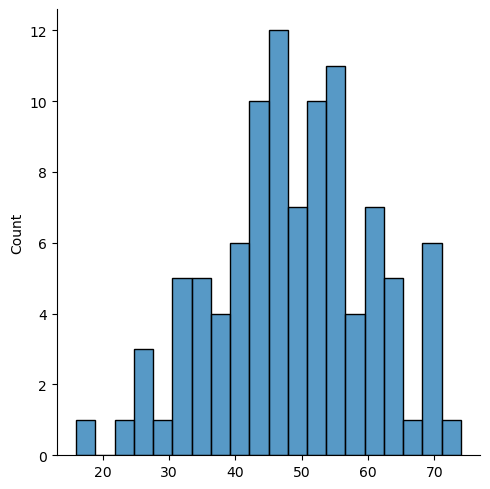

In [28]:
plt.figure(figsize=(12, 8), dpi=200)
sns.displot(sample, bins=20)
plt.show()

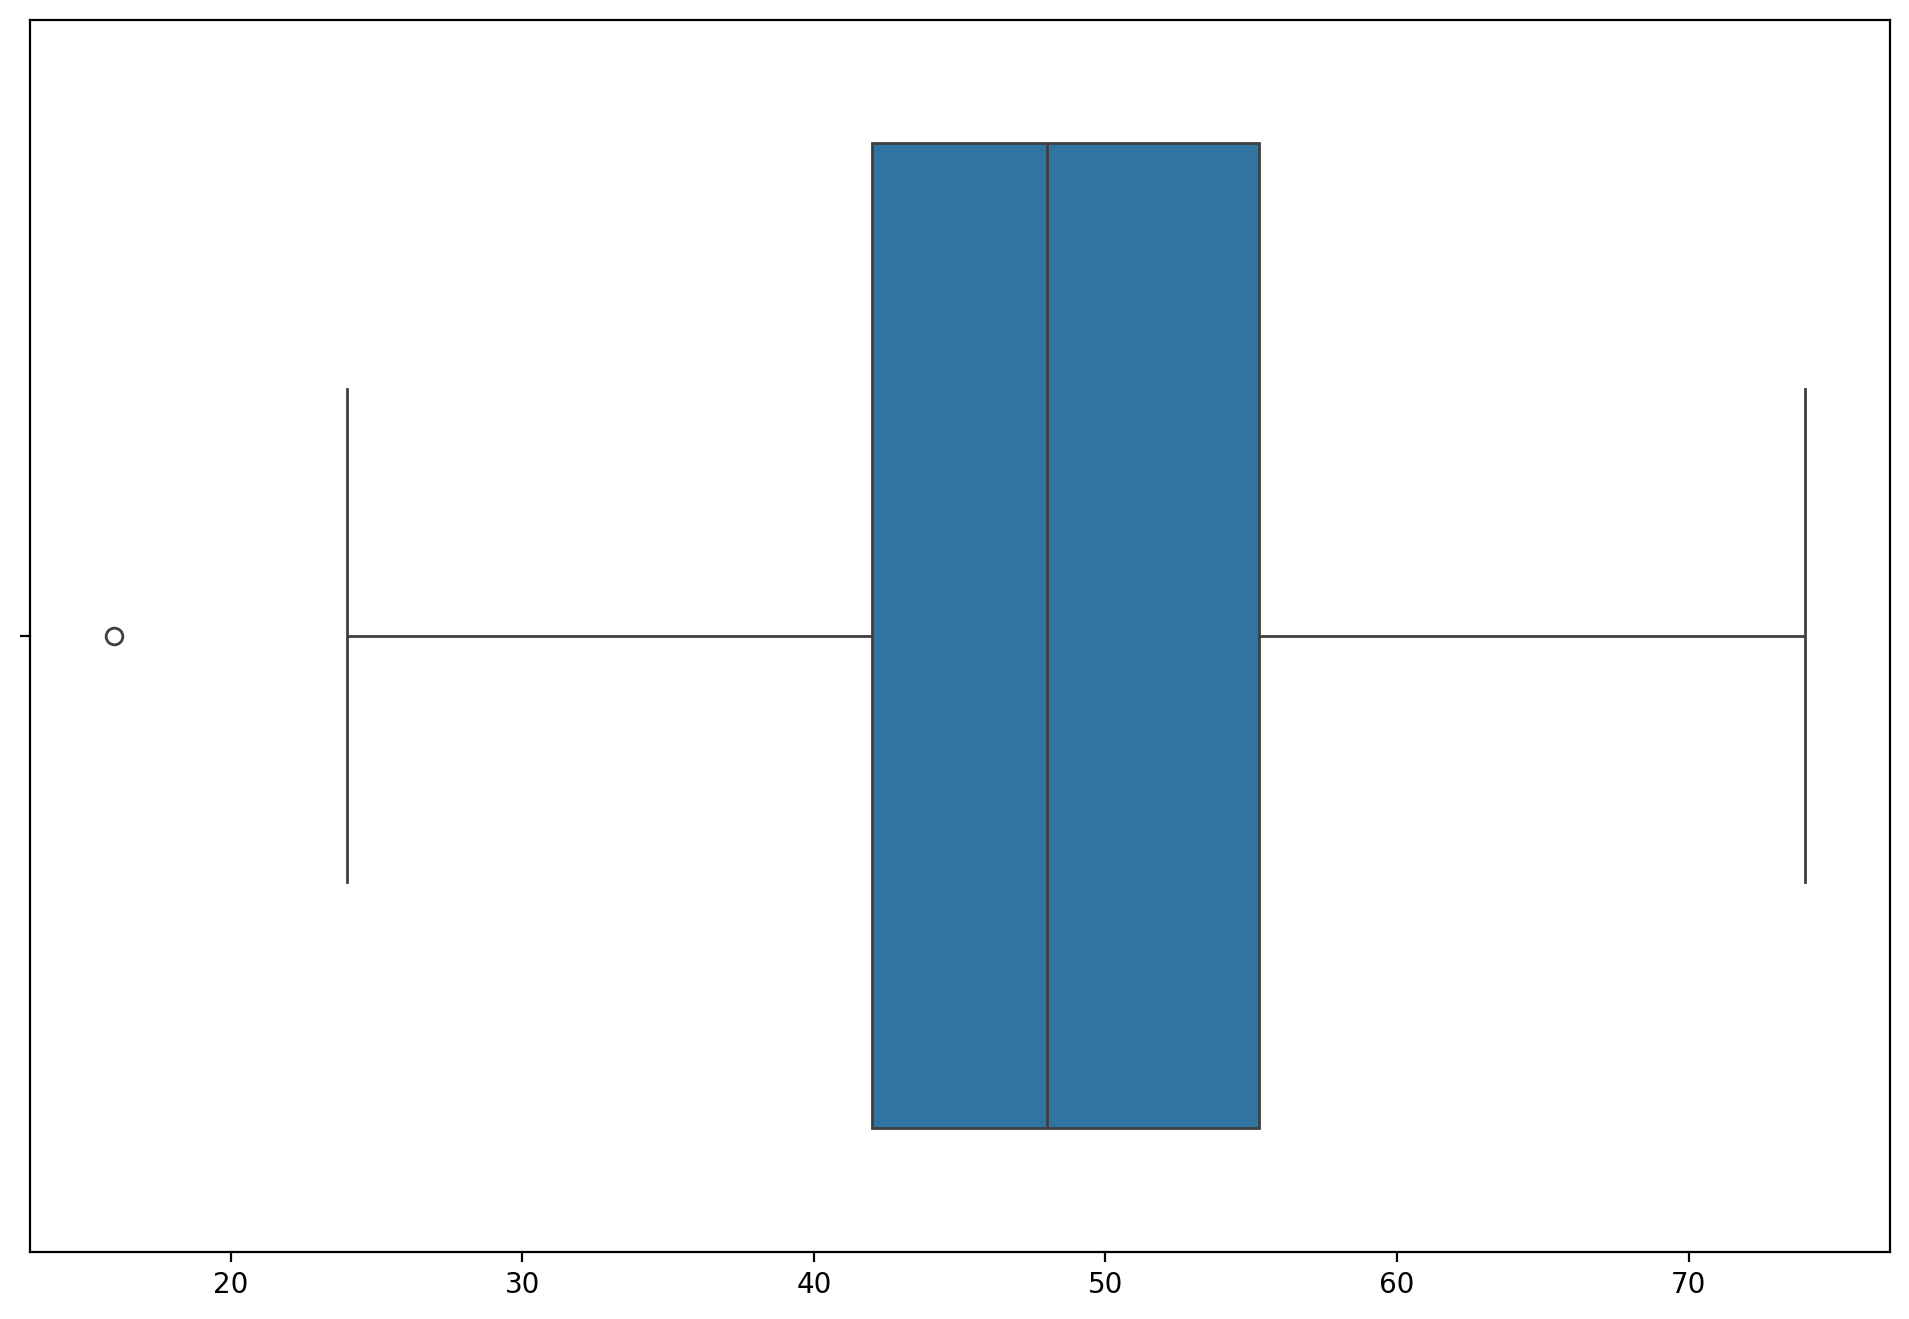

In [32]:
plt.figure(figsize=(12, 8), dpi=200)
sns.boxplot(x=sample)
plt.show()

На графике boxplot - слева можно увидеть точку, которая не уложилась в диапазон 1.5*IQR. Для того, чтобы найти эту точку численно создадим объект series на основе данных sample.

In [38]:
ser = pd.Series(sample)
ser.describe()

count    100.00000
mean      48.66000
std       11.82039
min       16.00000
25%       42.00000
50%       48.00000
75%       55.25000
max       74.00000
dtype: float64

Здесь можно увидеть числа, которые нужны для интерквартильного размаха.

In [41]:
IQR = 55.25000 - 42.00000
lower_limit = 42.00000 - 1.5 * IQR

In [43]:
lower_limit

22.125

In [49]:
# Можно сделать следующим образом
np.percentile(sample, [75, 25])

array([55.25, 42.  ])

In [51]:
np.percentile(sample, [75])

array([55.25])

In [53]:
q75, q25 = np.percentile(sample, [75, 25])

In [55]:
iqr = q75-q25

In [57]:
1.5*iqr

19.875

In [59]:
q25 - 1.5*iqr

22.125

## Усечение или исправление данных на основе знаний о данных
Получается на графике boxplot, в левой части, точка выброса находится левее нижней границы усов, которая равна = 22.125.
При желании можно отобрать только те точки, которые больше нижнего лимита.

In [46]:
ser[ser > lower_limit]

0     56.0
1     48.0
2     58.0
3     70.0
4     47.0
      ... 
95    31.0
96    54.0
97    53.0
98    50.0
99    47.0
Length: 99, dtype: float64

In [63]:
def fix_values(age):
    
    if age < 18:
        return 18
    else:
        return age

In [65]:
# "Исправляем" возраст одного человека
ser.apply(fix_values)

0     56.0
1     48.0
2     58.0
3     70.0
4     47.0
      ... 
95    31.0
96    54.0
97    53.0
98    50.0
99    47.0
Length: 100, dtype: float64

In [67]:
len(ser.apply(fix_values))

100

---
* https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
* https://towardsdatascience.com/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623
---

# Набор данных "Ames Data Set"

In [74]:
df = pd.read_csv('../DATA/Ames_Housing_Data.csv')
df.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


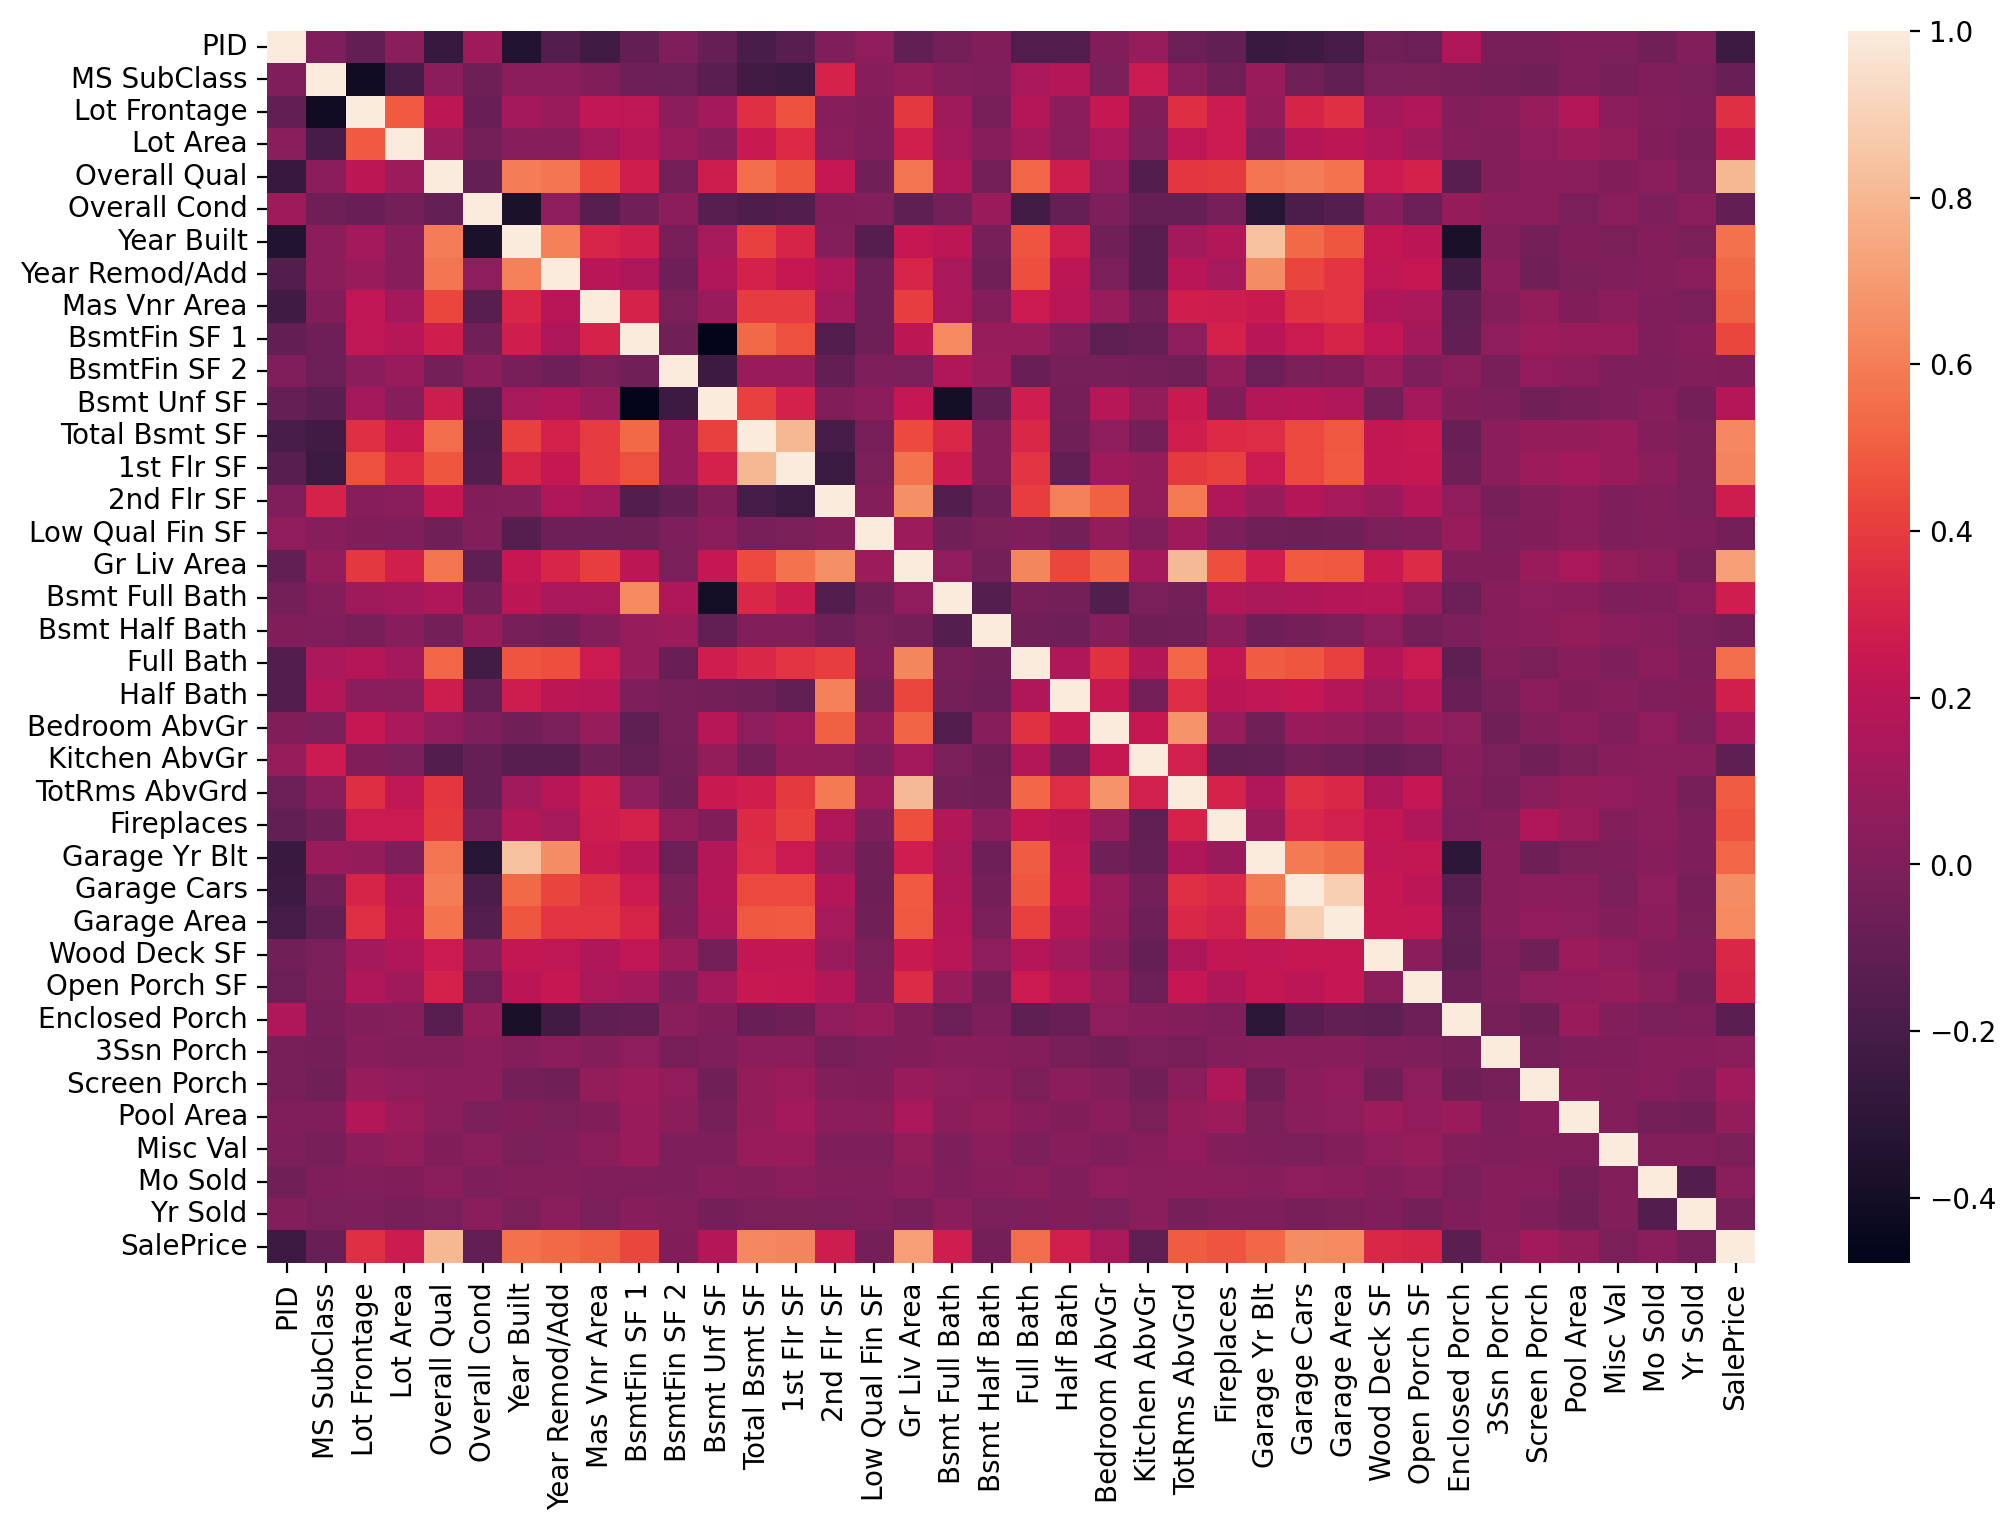

In [86]:
plt.figure(figsize=(12, 8), dpi=200)
sns.heatmap(df.corr(numeric_only=True))
plt.show()

In [80]:
df.corr(numeric_only=True)['SalePrice'].sort_values()

PID               -0.246521
Enclosed Porch    -0.128787
Kitchen AbvGr     -0.119814
Overall Cond      -0.101697
MS SubClass       -0.085092
Low Qual Fin SF   -0.037660
Bsmt Half Bath    -0.035835
Yr Sold           -0.030569
Misc Val          -0.015691
BsmtFin SF 2       0.005891
3Ssn Porch         0.032225
Mo Sold            0.035259
Pool Area          0.068403
Screen Porch       0.112151
Bedroom AbvGr      0.143913
Bsmt Unf SF        0.182855
Lot Area           0.266549
2nd Flr SF         0.269373
Bsmt Full Bath     0.276050
Half Bath          0.285056
Open Porch SF      0.312951
Wood Deck SF       0.327143
Lot Frontage       0.357318
BsmtFin SF 1       0.432914
Fireplaces         0.474558
TotRms AbvGrd      0.495474
Mas Vnr Area       0.508285
Garage Yr Blt      0.526965
Year Remod/Add     0.532974
Full Bath          0.545604
Year Built         0.558426
1st Flr SF         0.621676
Total Bsmt SF      0.632280
Garage Area        0.640401
Garage Cars        0.647877
Gr Liv Area        0

**Когда признаков слишком много, легче начать исследование данных с тех признаков, которые сильнее всего коррелируют с целевой переменной. Поскольку очистка данных является достаточно трудоёмким процессом.**

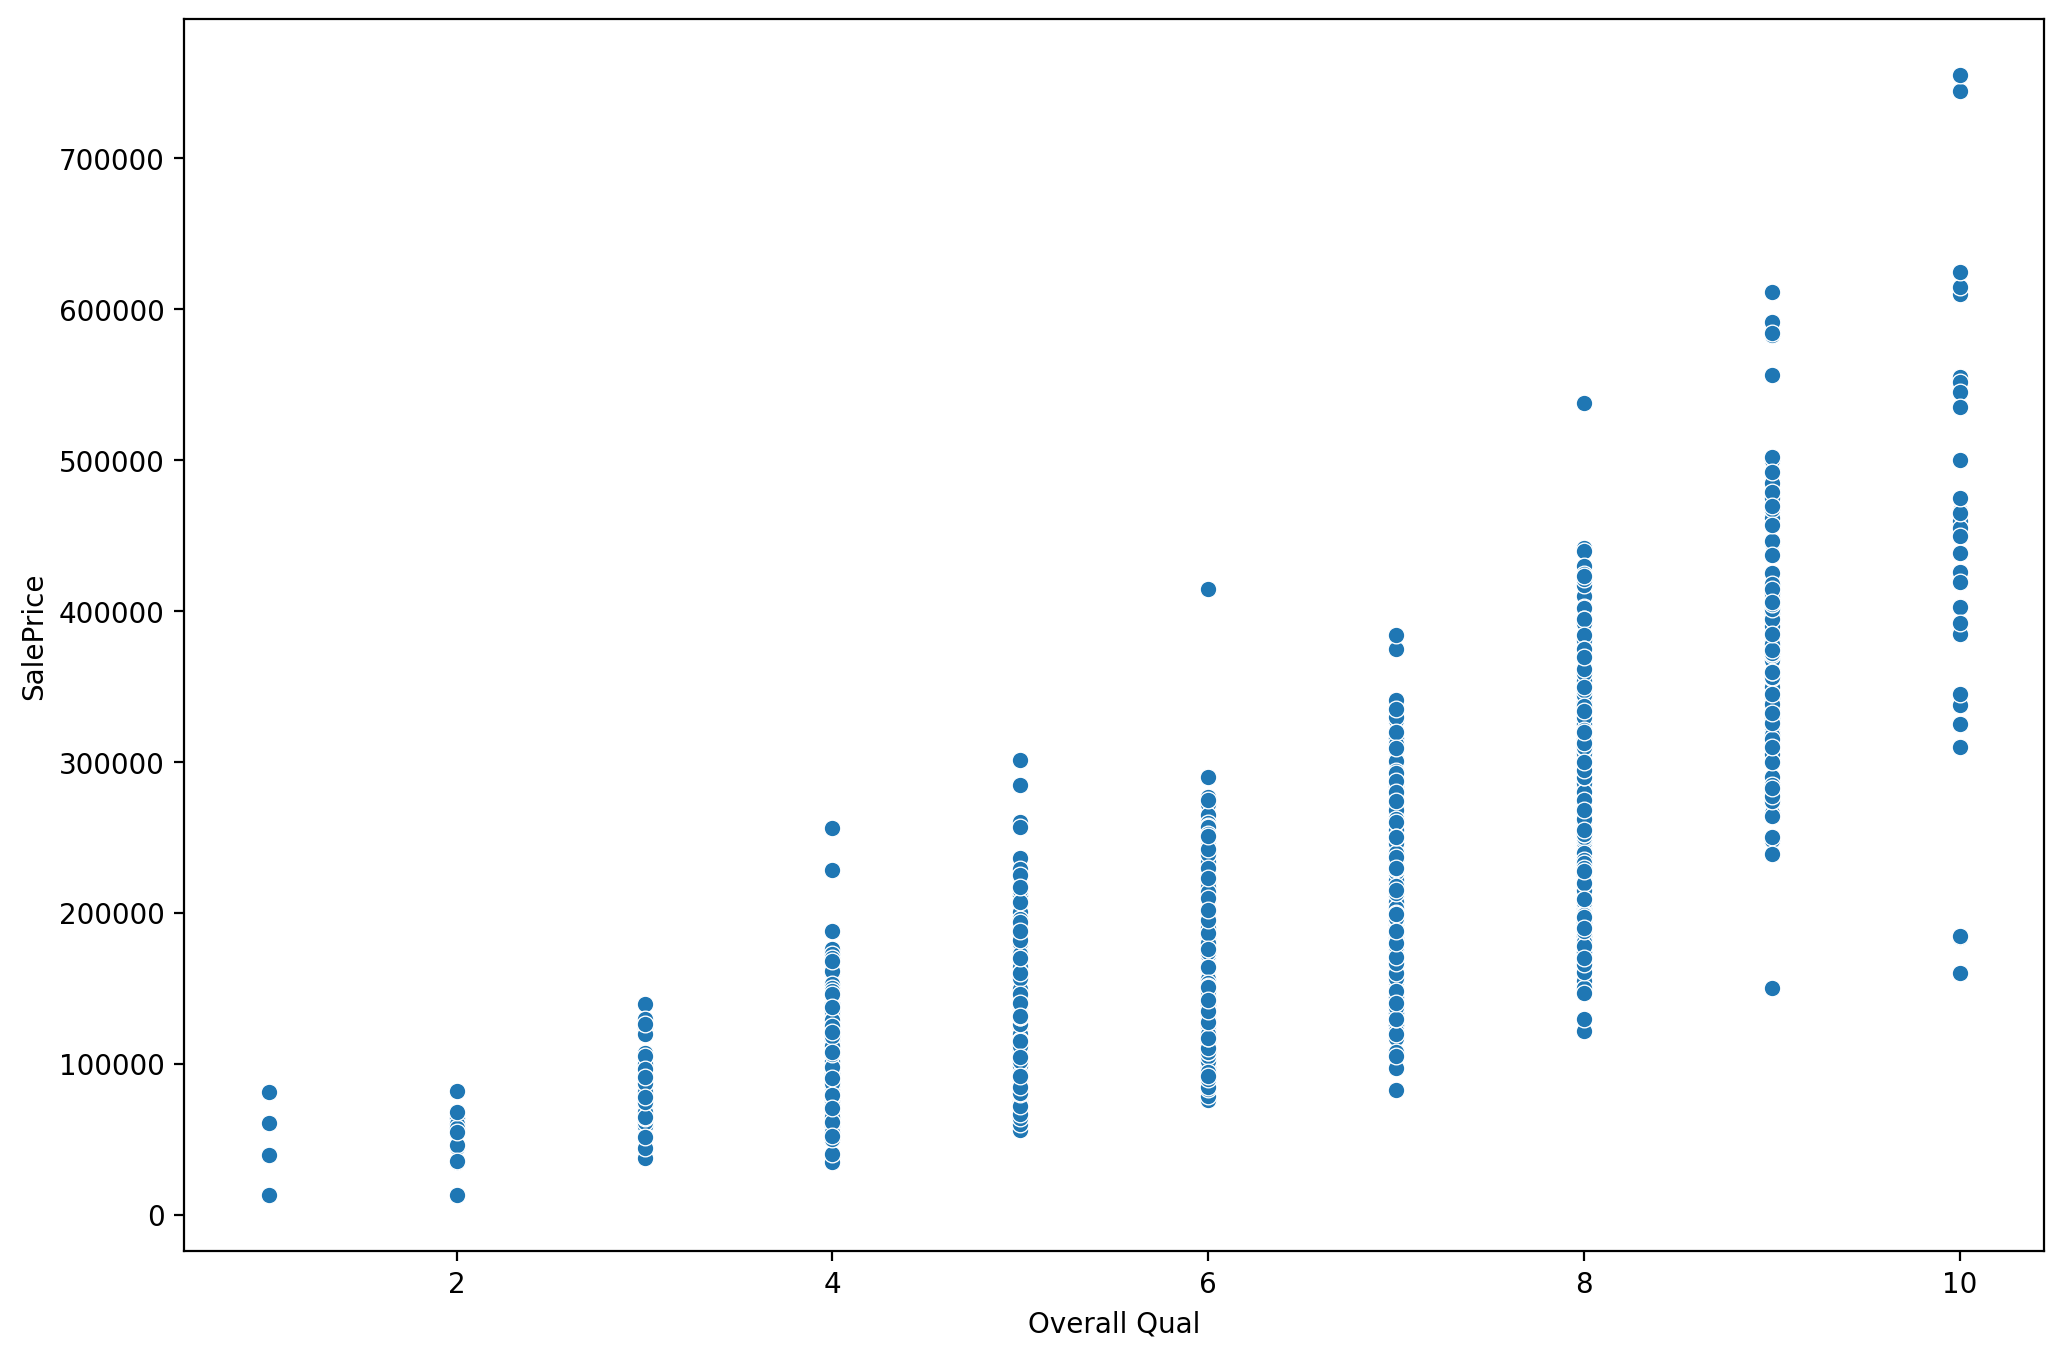

In [88]:
plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(data=df, x='Overall Qual', y='SalePrice')
plt.show()

На графике scatterplot видно, что колонка Overall Qual принимает только целые значения в диапазоне от 1 до 10. На графике можно заметить точки, которые могут быть классифицированы как выбросы. По графику видно, что чем больше значения Overall Qual, тем выше SalePrice.

Однако, есть три дома, которые имеют оценку 9 и 10, но они продаются по значительно меньшей цене, что остальные дома в этой категории Overall Qual. Их цена больше похожа, на цену Overall Qual = 5. Есть выбросы и в обратную сторону, для Overall Qual = 6 есть одна точка, которая выбивается из общей картины для этой категории домов. То же самое можно сказать и про точку для Overall Qual = 8.

Если мы посмотрим на Overall Qual = 10, то здесь мы в целом видим более широкий диапазон значений по вертикали. Вопрос о том, нужно ли в таком случае считать две верхние точки выбросами - требует дополнительного исследования.

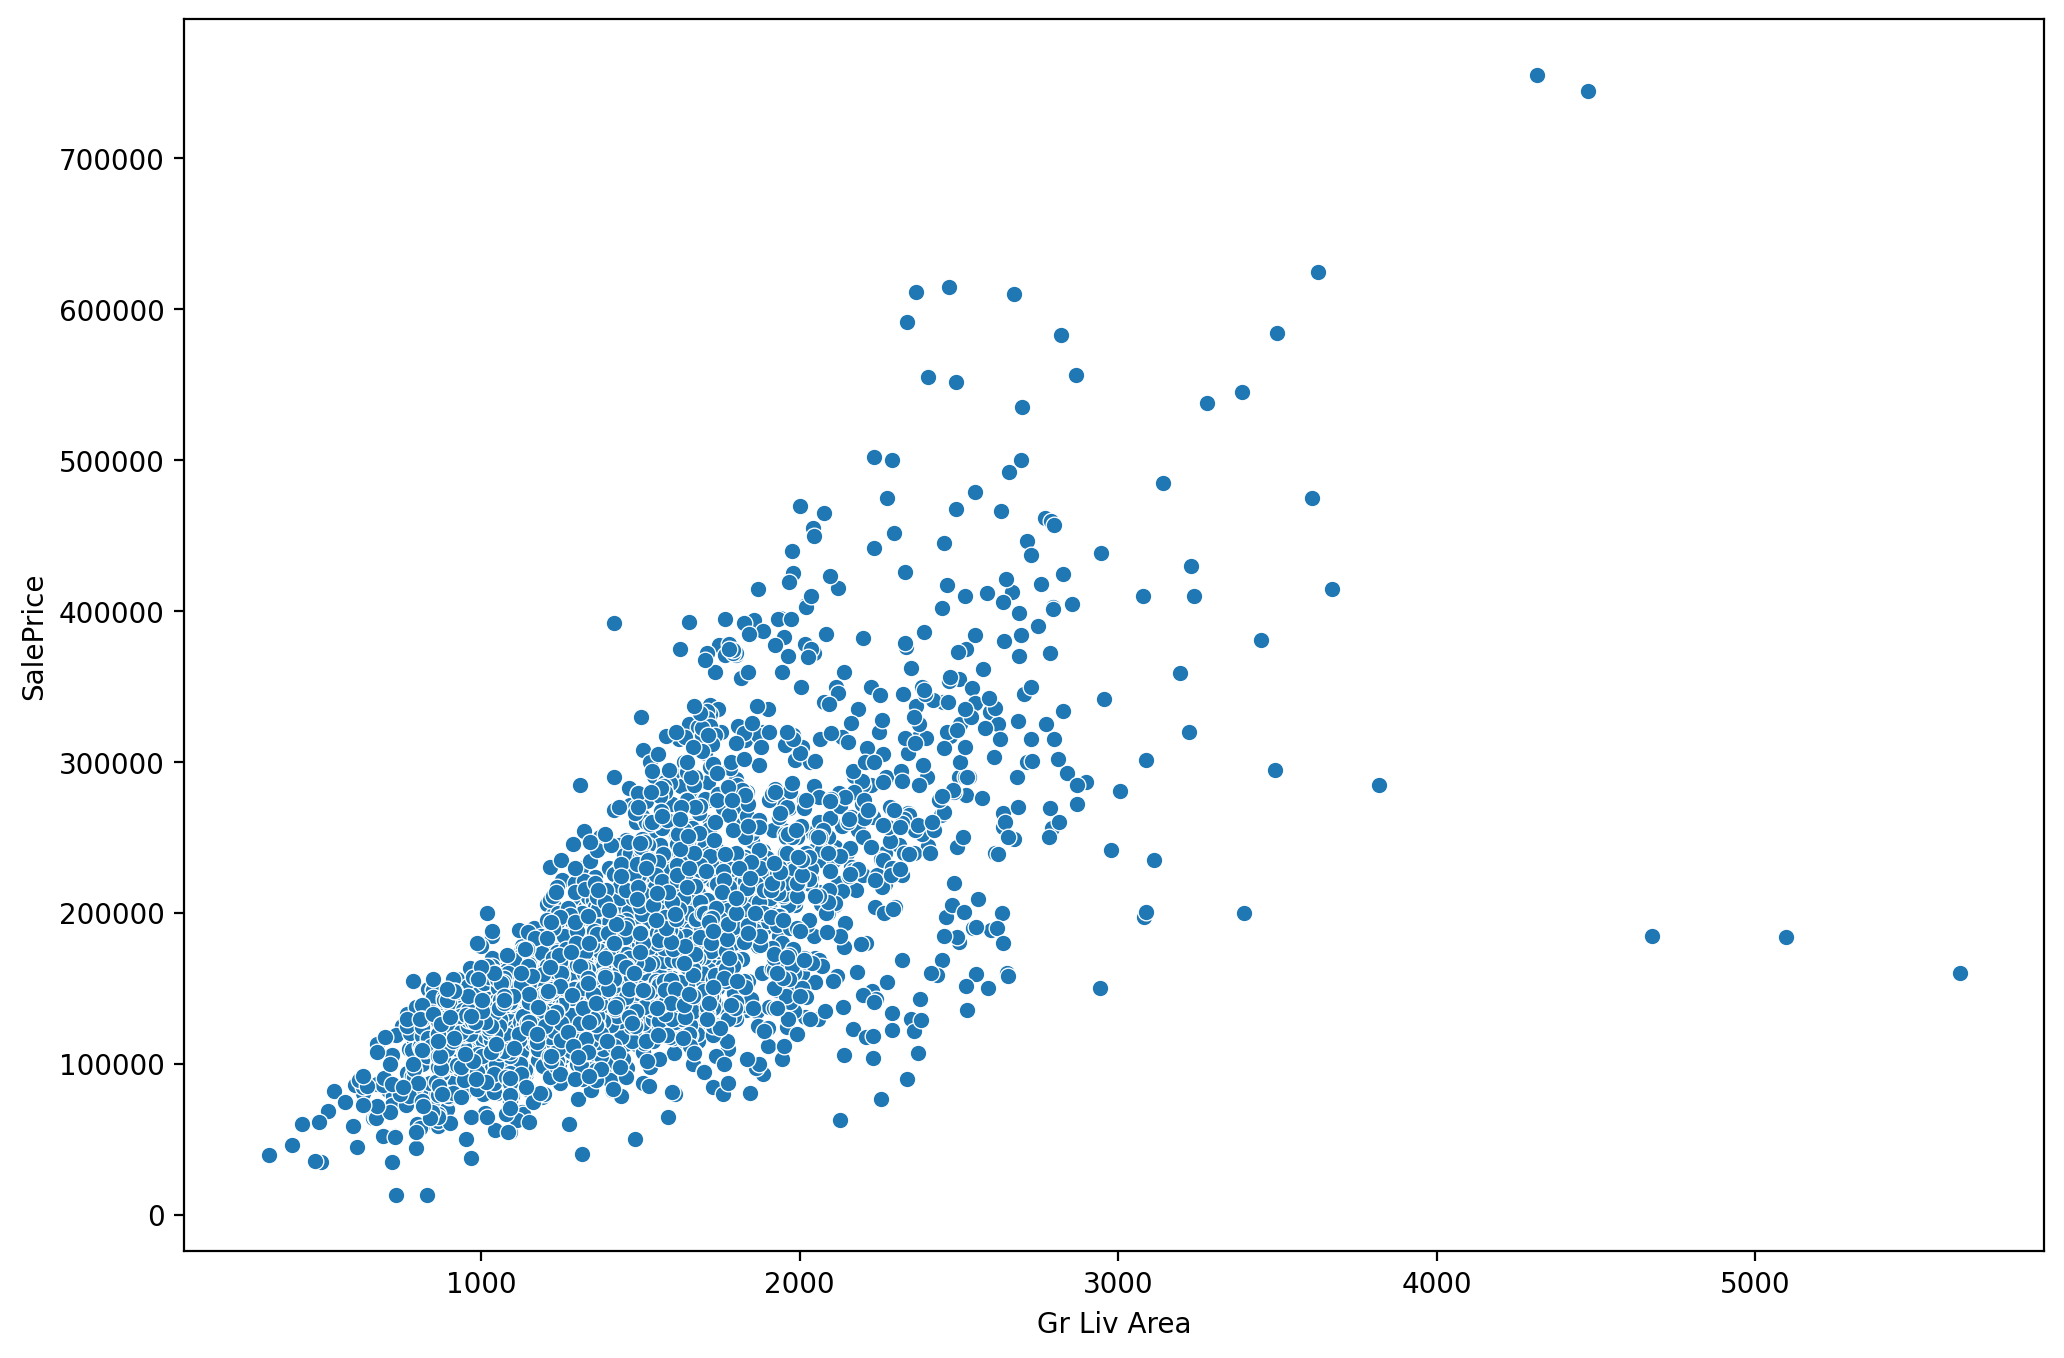

In [92]:
plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(data=df, x='Gr Liv Area', y='SalePrice')
plt.show()

В правой части этого графика, можно сразу заметить три точки, выпадающие из общеё картины. Это точки с большой площадью дома, но при этом с низкой ценой продажи. Они могут нарушить общий тренд - при котором: чем больше площадь дома, тем больше его цена продажи. Такие вбыросы хотелось бы удалить из данных, так как они могут негативно повлиять на модель.

Также, мы видим две точки сверху - это дома с большой площадью, которые продаются по большой стоимости. Они не являются выбросами, которые могут нарушить общий тренд.

In [96]:
df[(df['Overall Qual'] > 8) & (df['SalePrice'] < 200_000)]

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
1182,533350090,60,RL,NaN,24572,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Family,150000
1498,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
2180,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,Elev,17000,10,2007,New,Partial,183850
2181,908154205,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750


Мы получаем 4 дома для которых Overall Qual строго больше 8, но цена дома меньше 200000.

In [102]:
df[(df['Gr Liv Area'] > 4000) & (df['SalePrice'] < 200_000)]

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
1498,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
2180,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,Elev,17000,10,2007,New,Partial,183850
2181,908154205,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750


Получаем три дома, которые также присутствуют в предыдущем списке из четырёх строк. Четверётый дом, который мы получили в предыдущем списке, но не получили здесь, возможно, придётся исследовать отдельно по другим признакам.

## Удаление записей, классифицированых как выбросы

In [106]:
drop_ind = df[(df['Gr Liv Area'] > 4000) & (df['SalePrice'] < 200_000)].index

In [108]:
# axis=0 - для строк
df = df.drop(drop_ind, axis=0)

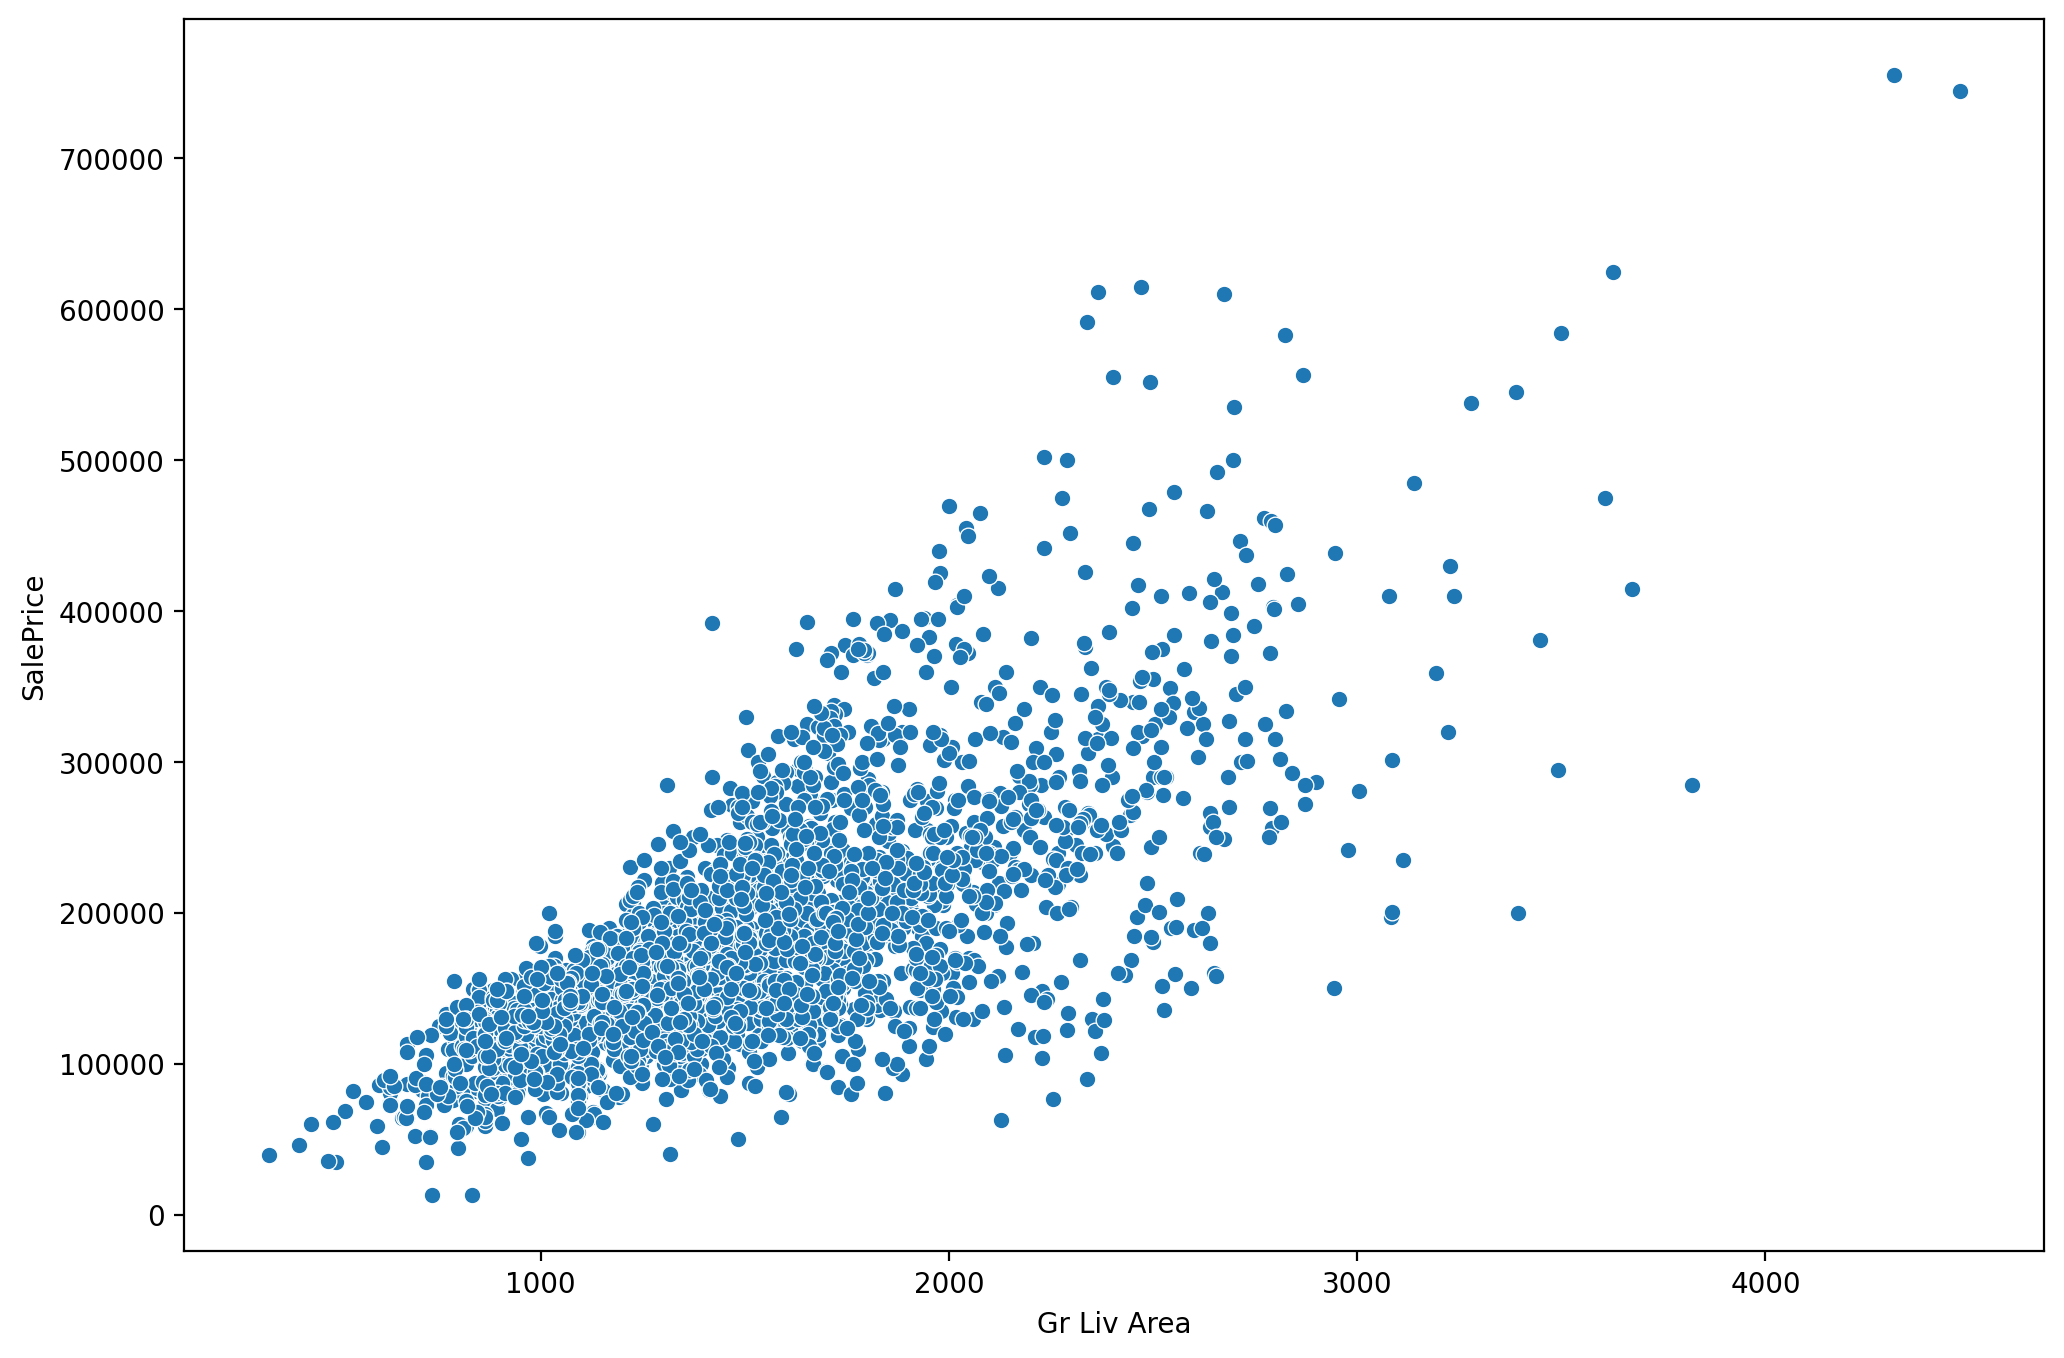

In [110]:
plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(data=df, x='Gr Liv Area', y='SalePrice')
plt.show()

Теперь мы можем видеть общий положительный тренд, что при увеличении площади дома, его цена тоже увеличивается.

**Важно: этого результата мы добились удалив три записи из датафрейма. Возможно, это были случайные дома, но они также могли бы оказаться каким-то новым трендом в данных!**

## Сохранение отредактированного датафрейма.

In [114]:
df.to_csv('Ames_my_Outliers_removed.csv')

---